# Imports

This Lab uses numpy, matplotlib, pillow, pandas, scipy, scikit-learn and scikit-image.

In [12]:
#imports

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import rgb2lab, lab2rgb
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans


# Image Imports

**Ensure you modify "seleced_image" to specify the image you want to use**

This imports the image and does necessary preprocessing for KMeans, and then shows a visualizaton of how it places the pixels in the LAB colorspace.

For more information on the LAB colorspace visit: https://en.wikipedia.org/wiki/CIELAB_color_space


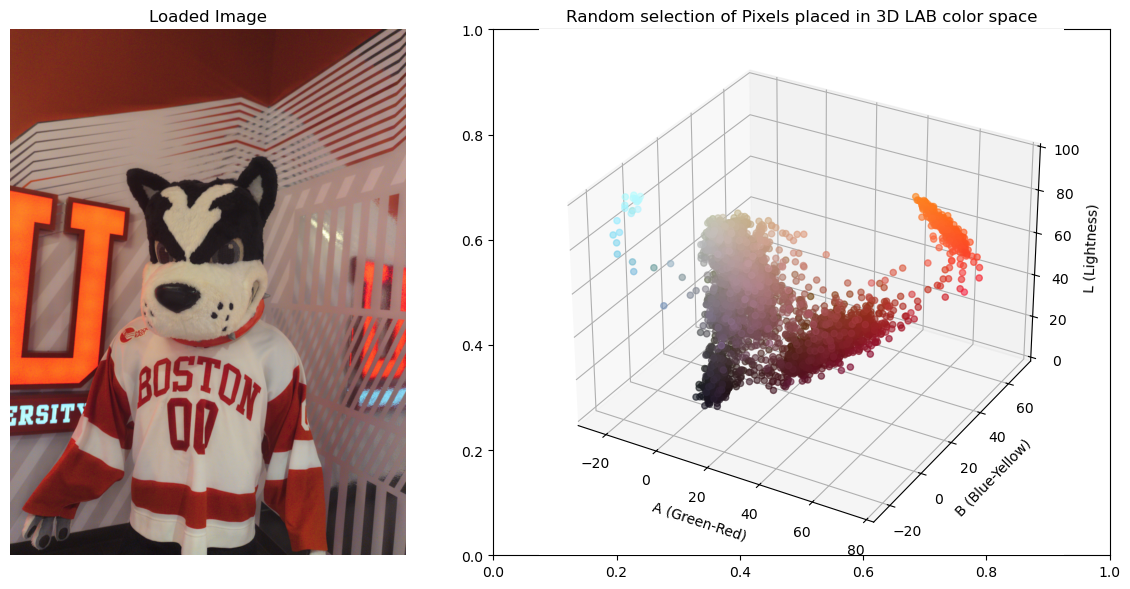

In [13]:
selected_image = "image5.png" # TODO: Change this to what you plan on using

### IMPORTING THE IMAGE

# This opens the image and converts it to an array of dimensions (image height) x (image width) x 3 (for red, green, blue channels)
image = Image.open(selected_image).convert("RGB")
image_np = np.array(image) / 255.0 #converts range of values from [0,255] to [0,1] for skimage.

#Converts the colorspace from RGB to LAB Colorspace
image_lab = rgb2lab(image_np)

# Converts the dimensions from (height) x (width) x 3  to (height * width) x 3 for easy iteration
h, w, c = image_lab.shape #for use when reshaping back
pixels = image_lab.reshape((-1, 3))

### CREATING MATPLOT VISUALIZATION

# Random selection of 5000 pixels
sample_indices = np.random.choice(pixels.shape[0], 5000, replace=False)

# Create Base Image
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1.2]})
axes[0].imshow(image_np), axes[0].set_title("Loaded Image"), axes[0].axis("off") #left image

# 3D LAB Plot
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.scatter(pixels[sample_indices][:, 1], pixels[sample_indices][:, 2], pixels[sample_indices][:, 0],
           c=image_np.reshape((-1, 3))[sample_indices], alpha=0.6)
ax.set(xlabel="A (Green-Red)", ylabel="B (Blue-Yellow)", zlabel="L (Lightness)", title="Random selection of Pixels placed in 3D LAB color space")

plt.tight_layout()
plt.show()



# KMeans Implementation

Below is an implimentation of KMeans, split into two parts.

- **initialize_centroids**: either using random, or KMeans++ initialization, this creates an initial set of centroids

- **image_kmeans**: Full implementation of KMeans, initializing the centroids using **initialize_centroids** and then running LLoyd's algorithm until the centroids converge or a set amount of iterations has passed.

In [21]:

colors=10 #Numbers of colors (10 recommended, feel free to try different numbers!)
iterations=10 #Maximum amount of iterations when running Lloyd's algorithm
initialize_plusplus = True #Set to True once you implement the KMeans++ initialization.

np.random.seed(30)

'''
    initialize_centroids

    As the first step in KMeans, this function creates and returns the initial cluster positions when given a dataset.

    inputs:
        data - a 2D array sized (pixels in image) x (3).
            pixels[i] returns an array of size 3 representing the [L,A,B] values for pixel i.
        k - the number of clusters to initialize.
        method - set to either 'random' or 'kmeans', determining the initialization type

    returns:
        centroids - a subset of the data array; sized (k) x 3.
            centroids[i] returns an array of size 3, representing the [L,A,B] values for initialized cluster i.
'''
def initialize_centroids(data, k, method='random', n_init=10):
    best_centroids = None
    best_score = -np.inf

    for _ in range(n_init):
        if method == 'random':  # Random Initialization
            centroids = data[np.random.choice(len(data), k, replace=False)] #selects k random centroids

        elif method == 'kmeans++':
            centroids = [data[np.random.randint(len(data))]] #Find first centroid
            for i in range(1, k):
                distances = np.empty(len(data))
                for index, x in enumerate(data):
                    min_dist = np.inf
                    for c in centroids:
                        dist = distance(x, c)
                        if dist < min_dist:
                            min_dist = dist

                    distances[index] = min_dist

                probabilities = distances / distances.sum()

                new_centroid_index = np.random.choice(len(data), p=probabilities)
                new_centroid = data[new_centroid_index]
                centroids.append(new_centroid)
            centroids = np.array(centroids)
                
    
        # Calculating best scores
        centroid_distances = cdist(centroids, centroids, metric='euclidean')
        np.fill_diagonal(centroid_distances, np.inf)

        min_dist = np.min(centroid_distances, axis=1)
        score = np.max(min_dist)

        if score > best_score:
            best_score = score
            best_centroids = centroids

    return best_centroids



def distance(p1, p2):
    return np.sum((p1-p2) ** 2)




#Full implementation of KMeans for image processing
def image_kmeans(data, k, max_iters=10, init='random'):

    #Initialize the centroids here
    print("Initializing Centroids by", init)

    # TODO 3: Implement initiaization optimization here.
    centroids = initialize_centroids(data, k, method='kmeans++') #creates centroids

    print("Centroids Initialized!")

    #Iterates LLoyd's algorithm a set amount of times to place an upper bound to how much processing time is used
    for q in range(max_iters):
        print("LLoyd's Iteration ", q+1, " out of ", max_iters)

        # Finding the distances of each point from each centroid

        # TODO EX: Experiment with different functions/metrics for distance
        distances = cdist(data, centroids, metric='euclidean')
        labels = np.argmin(distances, axis=1) #sets the label/cluster of each point to its closest centroid

        # Find new centroids by averaging positions in newly modified labels
        # TODO EX 2: Experiment with different functions for calculating the new centroids
        centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                                  for i in range(k)])

    return labels, centroids

#calls the image_kmeans function to get the labels for each pixel alongside the centroids themselves
labels, centroids = image_kmeans(pixels, colors, init='kmeans++' if initialize_plusplus else 'random')

# Assign each pixel the color of its cluster centroid
clustered_pixels = centroids[labels]

Initializing Centroids by kmeans++
Centroids Initialized!
LLoyd's Iteration  1  out of  10
LLoyd's Iteration  2  out of  10
LLoyd's Iteration  3  out of  10
LLoyd's Iteration  4  out of  10
LLoyd's Iteration  5  out of  10
LLoyd's Iteration  6  out of  10
LLoyd's Iteration  7  out of  10
LLoyd's Iteration  8  out of  10
LLoyd's Iteration  9  out of  10
LLoyd's Iteration  10  out of  10


# Output

**The code here does not need to be modified.**

This shows the final image with the color reduction applied, with charts showing how the clusters seperated the colorspace.

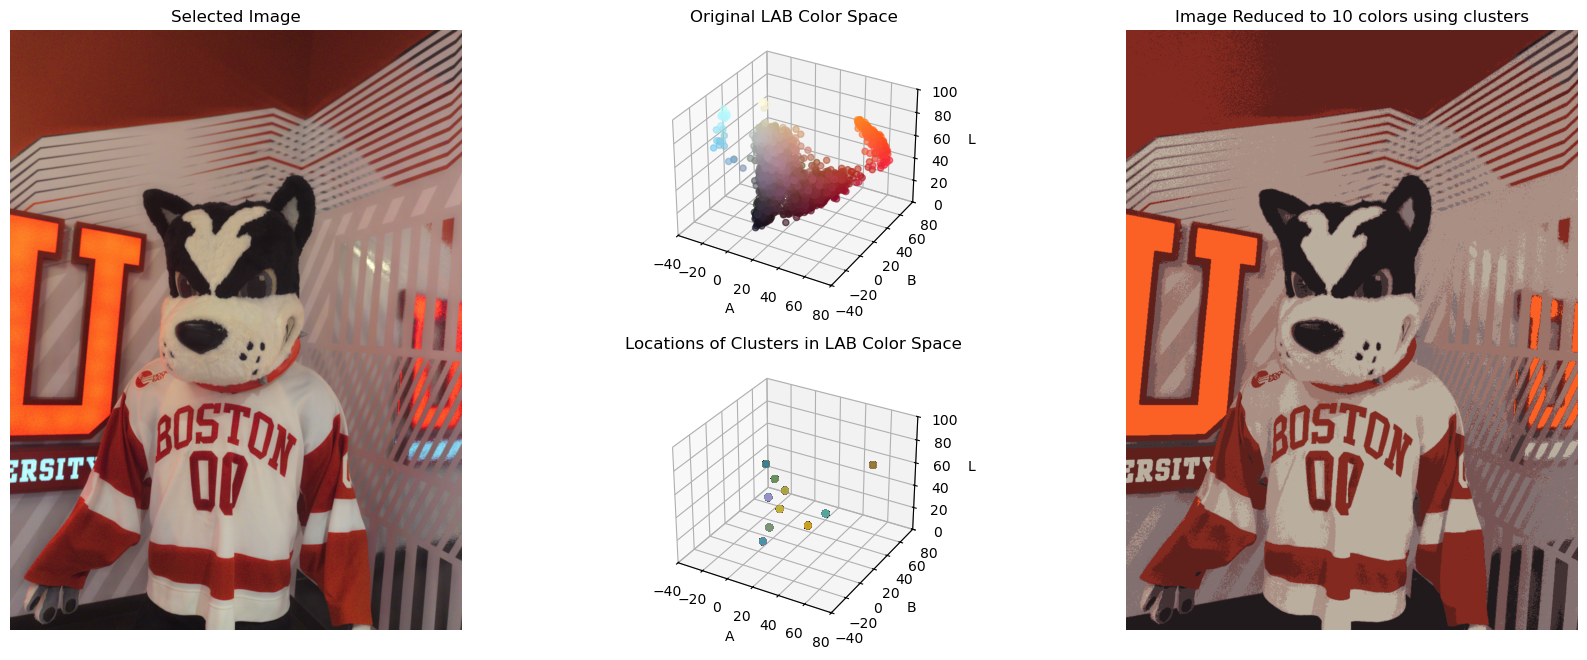

In [22]:
clustered_image_lab = clustered_pixels.reshape((h, w, 3))
clustered_image_rgb = lab2rgb(clustered_image_lab)

# Random selection of 5000 pixels
sample_indices = np.random.choice(pixels.shape[0], 5000, replace=False)
sample_pixels = pixels[sample_indices]
clustered_sample = clustered_pixels[sample_indices]

# Create figure and layout
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 0.5, 1])

# Left - Original Image
ax1 = fig.add_subplot(gs[:, 0])
ax1.imshow(image_np)
ax1.set_title("Selected Image")
ax1.axis("off")

# Middle Top - Color space (same as first visual)
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax2.scatter(sample_pixels[:, 1], sample_pixels[:, 2], sample_pixels[:, 0],
            c=image_np.reshape((-1, 3))[sample_indices], alpha=0.6)
ax2.set(xlabel="A", ylabel="B", zlabel="L", title="Original LAB Color Space")
ax2.set(**{ 'xlim': (-40,80), 'ylim': (-40,80), 'zlim': (0, 100) })

# Middle Bottom - Clusters within color space
ax3 = fig.add_subplot(gs[1, 1], projection='3d')
ax3.scatter(clustered_sample[:, 1], clustered_sample[:, 2], clustered_sample[:, 0],
            c=np.arange(len(clustered_sample)), cmap="tab10", alpha=0.6)
ax3.set(xlabel="A", ylabel="B", zlabel="L", title="Locations of Clusters in LAB Color Space")
ax3.set(**{ 'xlim': (-40,80), 'ylim': (-40,80), 'zlim': (0, 100) })

# Right - Processed Image
ax4 = fig.add_subplot(gs[:, 2])
ax4.imshow(clustered_image_rgb)
ax4.set_title(f"Image Reduced to {colors} colors using clusters")
ax4.axis("off")

# Adjust spacing
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.08, hspace=0.2)
plt.show()

# Save figure
fig.savefig(f"Submission{'Final' if initialize_plusplus else 'Baseline'}.png", bbox_inches="tight", pad_inches=0.5)

# Your Task

If you haven't seen the video, make sure to visit the lab discord channel and view it; it gives preliminary background information and describes the task for this lab (alongside giving some pointers!).

Provided in this file is a fully functional implementation of KMeans; you could change the selected image in the second code block, and run the cells to see the process run.

Your task for this lab is improving the effectiveness of this implementation, by making improvements to the initialization itself. This is split into four parts:

1. **Create a baseline**

Using the default initialization, pick an image and a set amount of colors, and run the image initialization, KMeans implementation, and then Output cells. This will be the baseline you compare against when making improvements, so we recommend using 5-10 colors as this makes comparisons easier (feel free to use more, especially when using image2!). Keep track of the image and number of colors you used, as the same settings need to be used when creating the final output for comparison.

Once the output cell is run successfully, an image named `SubmissionBaseline.png` will be created; ensure this file is safe as this will be submitted to Gradescope.

Before you start making changes, make sure to set `initialize_plusplus` to `True` as this sets the initialization method to `KMeans++`; this also ensures that future outputs don't overwrite the baseline image file you created.


2. **Switching to Kmeans++**

The `initialize_centroids` function is currently implemented using random initialization. Your task is to complete the `Kmeans++` initialization type.
The very first step is already completed: selecting the first cluster at random; your job is to iteratively select every remaining cluster based on the description for `KMeans++` [given in lecture (click here!)](https://github.com/gallettilance/CS506-Spring2025/raw/main/lecture_05/05_Kmeans++.pdf).

Make sure to run the output and ensure that the results look somewhat in line with what you'd expect.

3. **Recreating Scikit's repetition**

One function that makes Scikit-learn's implementation of KMeans++ so effective is the `n_init` feature. The effectiveness of KMeans++ can be very dependent on which point is randomly selected as the first centroid. Scikit counteracts this by repeating the initialization `n_init` times with different starting points; finding the best output to return as the result of the algorithm.

Within the `image_kmeans` function, the first line of code calls `initialize_centroids`, using the centroids returned for the rest of the algorithm.

Your second task is to create a version of Scikit's optimization by running `initialize_centroids` a set amount of times, and finding which of these initializations is the best. The amount of times it is run and the metrics you choose to decide the best one are entirely up to your discretion! However, as a pointer, we recommend looking at trying to measure "spread" by finding the average distance between clusters (or finding the highest minimum distance between two clusters) within an initialization.

Ensure you compare your results with the default initialization and ensure that its results are an improvement over the default initialization.

4. **Output**

Using the same image and number of colors you used when creating the baseline, run the output code block, and compare the results of the newly created `SubmissionFinal.png` and the previously created `SubmissionBaseline.png`. Answer the comprehension questions below, and then feel free to submit the notebook alongside the two images to Gradescope!

# Comprehension Questions

The recommended length to answer these questions is 1-2 sentences.

1. **What exactly is the relationship between the images and the 3D spaces created? What is the relationship between the clusters and the pixels in both the original image and the color-reduced image?**

- The 3D space is the LAB color space with each the points representing the color of the pixels. Clusters group similar colors and the centroid is the donimant color of the image.

2. **When shifting from random initialization to KMeans++ (and making further optimizations), how does this seem to impact the clustering from the points in the color space?**

- The centroids are spread more evening across the space and making the clusters more balanced. 

3. **Based on your answer from above, how do you think these differences in clustering translate into generally better-looking results?**

- They result in more accurate representations of the original image, and it is especially visible in areas where there might be multiple different colors when comparing with the baseline.

4. **When trying to optimize KMeans++ by running it repeatedly, how did you approach the problem of finding the best iteration? What Metrics did you use? Did it give better results?**

- I found the highest min distances between the centroids, which means that the clusters are spread out and well-separated.


# Extra Credit Analysis

These problems are optional, for extra credit. We recommend answering these in 3-4 sentences.

5. **We have provided a TODO in the `image_kmeans` function; try experimenting with different distance metrics. Do any other metrics give comparable, or even better results? Do any metrics give worse, but more interesting results? How does using a different distance metric translate to different results?**

- (Answer Here)

6. **Could you find an example of an image where random initialization gains an advantage over KMeans++? Why exactly does it seem to give better results?**

- (Answer Here)
